In [1]:
import sys
import os
from IPython import display

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as torch_f

import batchflow as bs
from batchflow import Dataset, V,  B, C, R, action, Batch, Pipeline
from batchflow.research import Research
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch import TorchModel

sys.path.insert(0, '../fashion-mnist/utils')
import mnist_reader

sys.path.insert(0, '../batchflow_git/standards/')
from src import show_samples, class_histogram, show_loss, show_histogram, class_precision

## Dataset
For train and evaluation [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) was used.
It contains grayscale images (28x28 pixels) and consists of two parts: train (60k items) and test (10k items).
Each part comprises:
- an array of images of size 28х28 pixels in greyscale
- an array of labels corresponding to a object on each image.

Images and labels loading(loading method return flatten images with size 784):

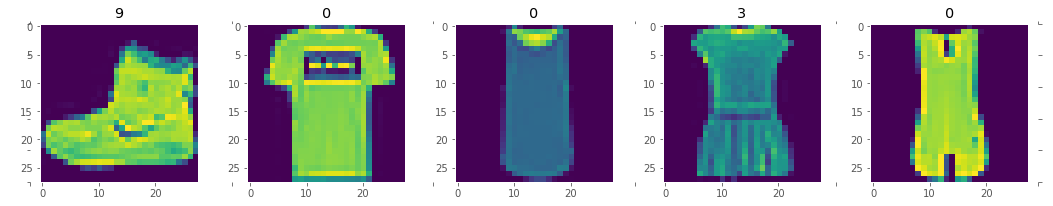

In [2]:
X_train, y_train = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('../fashion-mnist/data/fashion', kind='t10k')
image_shape = X_train.shape[1]
num_classes = 10
show_samples(X_train[:5].reshape(-1,28,28), labels=y_train[:5])

#### Comments
Class ```Batch``` is needed in order to determine the logic of loading data into the pipeline and perform any actions before loading data to the model (data type changes, augmentation, etc.). The ```components``` parameter defines the names that will be given to the inputs inside the batch. The ```action``` decorator allows you to create your own methods available in the pipeline. 

In [3]:
class FmnistBatch(Batch):
    components = ('images', 'labels')  # How add more information?
    
    @action
    def data_type(self):
        self.images = self.images.astype(np.float32)
        self.images = self.images / 255
        self.labels = self.labels.astype(np.int64)
        return self
    
    @action
    def plot_loss(self, loss):
        if len(loss) % 50 == 0:
            display.clear_output(wait=True)
            plt.style.use('ggplot')
            plt.figure(figsize=(5,3))
            ax = plt.subplot()
            ax.semilogy(loss)
            ax.set_ylabel('log_loss')
            ax.set_xlabel('#batches')
            plt.show()
        return self
    
    @action
    def shift(self, jit):
        img = self.images.reshape(-1,28,28)
        N, H, W = img.shape
        img = np.pad(img, [(0, 0), (0, jit), (0, jit)], mode='constant')
        j0 = np.random.randint(jit)
        j1 = np.random.randint(jit)
        img = img[:, j0 : H + j0, j1 : W + j1]
        self.images = img.reshape(-1, 784)
        return self

#### Comments
Сlass ```Dataset``` combines the indices of dataset objects or file paths together with the batch processing logic, which allows loading data from the hard drive directly at the time of the pipeline execution. A class object can be split into train, test and validation subsets. All parts are also datasets, which can be addressed as ```dataset.train```, ```dataset.test``` and ```dataset.validation```.

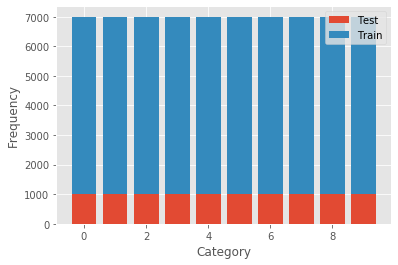

In [4]:
train_ds = Dataset(len(y_train), 
                  batch_class=FmnistBatch) 
test_ds = Dataset(len(y_test),
                  batch_class=FmnistBatch)

train_ = train_ds.next_batch(len(train_ds)).load(src=(X_train, y_train))
test_ = test_ds.next_batch(len(test_ds)).load(src=(X_test, y_test))
class_histogram(train_, test_)

## Model architecture

logistic regression is implemented using a model consisting of one Dense layer. The input number of neurons corresponds to the dimension of the flatten image, the output number of neurons corresponds to the number of possible classes.

* `f` - dense


Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

#### Comments
To construct the model class ```TorchModel``` was used. Class object consist of three main blocks:```initial_block```, ```body```, and ```head```. ```initial_block``` just transforms the raw inputs into manageable tensors for a regular body structure. For this block ```'initial_block/inputs': 'images'```, ```'inputs/labels/classes'```, ```'inputs/images/shape'``` must be given in order to determine the input data for the model. The initial block’s output goes into ```body``` as inputs. The body produces a task-independent embedding of input tensors. The body's output goes into ```head``` as inputs. The Head produces outputs for specific tasks. Each block can be constructed using building blocks, for example, ```ConvBlock``` whose structure is determined by ```layout```. ```output``` determine what parameters are additionally calculated from the model output (probabilities, predictions for classes).

In [5]:
model_config = {
    'inputs/images/shape': image_shape,
    'inputs/labels/classes': num_classes,
    'initial_block/inputs': 'images',
    'body': dict(layout='f', units=10),
    'output': ['proba'],
}

## Training

The model is trained using stochastic gradient descent. On each iteration
* mini-batch data is loaded
* the model weights are updated 

An algorithm of the weights update (optimizer) is the Adam with following parameters:
* ```learning_rate``` = 0.001
* ``` betas``` = (0.9, 0.999)
* ```Weight_decay``` = 0.0001


Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 100
* ```n_epochs``` = 5
* ```validation_size``` = 0.2

In [6]:
model_config.update({'loss': 'CrossEntropy', # without ...Loss if use torch.nn losses !!!
                     'device': torch.device('cuda'),
                     'optimizer': {'name':'Adam', 'lr': 0.001, 'weight_decay':1e-4}
                    })
VALL_SPLIT = (0.8, 0.0, 0.2) #train/test/val
BATCH_SIZE = 100
EPOCHS = 5

Training pipeline:

#### Comments
We define a pipeline, in which data is loaded into the batch, and preprocessed. The internal variables of the pipeline are defined, the model is initialized and trained. Parameters for a late run are determined

In [7]:
train_template = (Pipeline()
                  .load(src=(X_train, y_train))
                  .data_type()
                  .init_variable('loss_history', default=[])  # Changed from init_on_each_run=list
                  .init_model('dynamic', TorchModel, 'logistic', config=model_config)
                  .train_model('logistic', B('images'), B('labels'), fetches='loss',  # Order of inputs? fetches-what will be return
                               save_to=V('loss_history', mode='a'))
#                   .plot_loss(V('loss_history'))
                  .run_later(BATCH_SIZE, shuffle=True, n_epochs=EPOCHS, drop_last=False, bar=True))

Execute training

In [8]:
train_ds.split(VALL_SPLIT)
train_pipeline = (train_template << train_ds.train).run()

100%|██████████| 2400/2400 [00:07<00:00, 320.57it/s]


The loss function vs number of iterations:

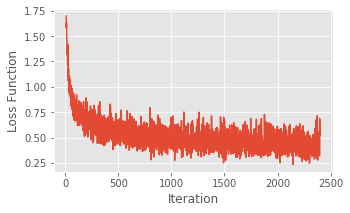

In [9]:
show_loss(train_pipeline.get_variable('loss_history'), skip=10)

## Validation inference

Prediction pipeline:

#### Comments
The pipeline for inference is practically no different from train, but ```predict_model``` is used instead of ```train_model```. ```gather_metrics```  allows calculating the confusion matrix to further evaluate the quality of the model

In [10]:
val_template = (Pipeline()
                    .import_model('logistic', train_pipeline)
                    .load(src=(X_train, y_train))
                    .data_type()
                    .init_variable('predictions', default=[])
                    .init_variable('metrics', default=None)
                    .predict_model('logistic', B('images'), fetches='proba',  # How calculate loss?
                                   save_to=V('predictions', mode='a'))
                    .gather_metrics('class', targets=B('labels'), predictions=V('predictions')[-1],
                                    fmt='proba', axis=-1, num_classes=10, save_to=V('metrics', mode='u'))
                    .run_later(BATCH_SIZE, n_epochs=1, drop_last=False, bar=True, shuffle=False))

Execute pipeline on validation part

In [11]:
val_pipeline = (val_template << train_ds.validation).run()

100%|██████████| 120/120 [00:00<00:00, 163.82it/s]


Quality metric, in this case, is ```accuracy``` on the validation set.

In [12]:
metrics = val_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.847


## Test inference
Prediction pipline:

In [13]:
test_template = (Pipeline()
                    .import_model('logistic', train_pipeline)
                    .load(src=(X_test, y_test)) 
                    .data_type()
                    .init_variable('predictions', default=[])
                    .init_variable('metrics', default=None)
                    .predict_model('logistic', B('images'), fetches='proba',
                                   save_to=V('predictions', mode='a'))
                    .gather_metrics('class', targets=B('labels'), predictions=V('predictions')[-1],
                                    fmt='proba', axis=-1, num_classes=10, save_to=V('metrics', mode='u'))
                    .run_later(BATCH_SIZE, n_epochs=1, drop_last=False, bar=True, shuffle=False))

Execute pipeline on test part

In [14]:
test_pipeline = (test_template << test_ds).run()

100%|██████████| 100/100 [00:00<00:00, 964.12it/s]


Prediction on first fifth test images:

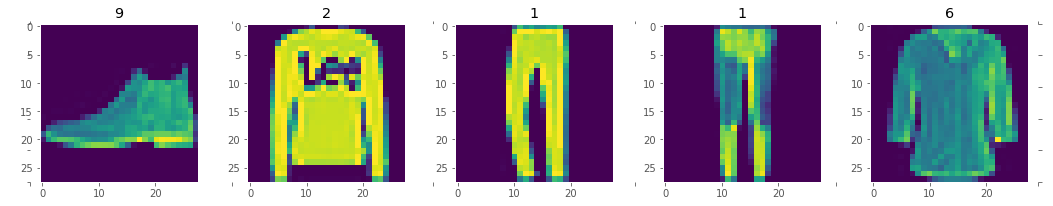

In [15]:
y_pred = np.concatenate(test_pipeline.get_variable('predictions'), axis=0)
show_samples(X_test[:5].reshape(-1,28,28), labels=np.argmax(y_pred[:5], axis=1))

Quality metric, in this case, is ```accuracy``` on the test set.

In [16]:
metrics = test_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.833


```confusion_matrix``` on 10 classes (rows and columns are numbered from 0 до 9 corresponding to the numbers on
the images):

In [17]:
print(metrics.confusion_matrix)

[[756   3  10  14   0   1 106   0   1   0]
 [  3 944   4  12   1   0   3   0   1   0]
 [ 21  12 822  21 211   0 173   0  12   0]
 [ 67  33  12 877  48   1  44   0  12   0]
 [  6   5  84  27 655   0  88   0   2   0]
 [  0   0   1   1   0 902   1  34   7  15]
 [133   1  62  45  80   0 568   0  23   1]
 [  0   0   0   0   0  59   0 930   7  44]
 [ 14   2   5   3   5   3  17   0 935   1]
 [  0   0   0   0   0  34   0  36   0 939]]


 `Precision` Histogram for each class:

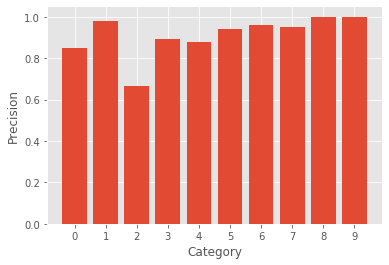

In [18]:
class_precision(metrics.confusion_matrix)

## Operating time

Device: NvidiaGeForce GTX 1050 Ti.

Training time is 5.55 s ± 43.5 ms.

Inference time is 86.3 ms ± 1.96 ms.

## Criticism
To identify weak spots of the model we performed model prediction on the shifted images.
To do so we added an image shift step to the prediction pipeline. An image is shifted on a random number of pixels from the uniform distribution in [0, 3]

In [19]:
criticism_template = (Pipeline()
                      .import_model('logistic', train_pipeline)
                      .load(src=(X_test, y_test))
                      .data_type()
                      .shift(jit=3)
                      .init_variable('predictions', default=[])
                      .init_variable('metrics', default=None)
                      .predict_model('logistic', B('images'), fetches='proba', 
                                     save_to=V('predictions', mode='a'))
                      .gather_metrics('class', targets=B('labels'), predictions=V('predictions')[-1],
                                      fmt='proba', axis=-1, num_classes=10, save_to=V('metrics', mode='u'))
                      .run_later(BATCH_SIZE, n_epochs=1, drop_last=False, bar=True, shuffle=False))

Run criticism pipeline

In [20]:
criticism_pipeline = (criticism_template << test_ds).run()

100%|██████████| 100/100 [00:00<00:00, 864.38it/s]


Compute `accuracy`

In [21]:
metrics = criticism_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.625


Accuracy decreased by 20%, which means the model is sensitive to a shift.

## Summary
The LogisticRegresion classifies images of clothes (grayscale, size 28х28) with test accuracy of 83.9%.

## Proposals for the improvement and further development

To improve classification (e.g. make it more robast to the image shift) we suggest to include augmentations to the training pipeline.

In [22]:
# train_pipe = (Pipeline()
#               .load(src=(X_train, y_train))#load data by index
#               .data_type()#convert to input datatypes
#               .init_variable('loss_history', init_on_each_run=list())#List for loss history
#               .init_model('dynamic',#created during the pipeline’s execution, allowing to create models adapting to batch size, content, shape and data types.
#                           LogReg,#model class
#                           'logistic',#model name
#                           config=config# print resulting model??
#                          )
#               .train_model('logistic',#which model train
#                            B('features'), B('labels'),#input and target,distributed according to shape??
#                            fetches=('loss'),#what will be return, can be list or tuple
#                            save_to=V('loss_history', mode='w')#append 'fetches' after each batch
#                           )
# #               .plot_loss(V('loss_history'))
#               .run(BATCH_SIZE, shuffle=True, n_epochs=EPOCHS, lazy=True))

# val_pipe  =(Pipeline()
#             .import_model('logistic',  C('import_from'))#import model from pipeline
#             .load(src=(X_train, y_train))
#             .data_type()
#             .init_variable('predictions')
#             .init_variable('metrics')
#             .predict_model('logistic', 
#                         B('features'),#how calc loss??
#                         fetches='predictions' ,
#                         save_to=V('predictions'))
#             .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'), num_classes=10,
#                                 fmt='logits', axis=-1, save_to=V('metrics', mode='a'))#fmt-outputs of the model, axis-direction to calc classes
#             .run(BATCH_SIZE, shuffle=False, n_epochs=1, lazy=True))
# research = Research()
# research.add_pipeline(train_pipe, dataset=train_ds, part='train', variables='loss_history', name='train')
# # research.add_pipeline(val_pipe, dataset=train_ds, part='test', variables='metrics', name='test', run=True, execute=-1, import_model='train')
# research.run( name='my_research', bar=True)